In [22]:
from sentence_transformers import SentenceTransformer, util

# model_path = 'bertmodel'
model_path = 'bert-base-cased'

model = SentenceTransformer(model_path)


No sentence-transformers model found with name bert-base-cased. Creating a new one with mean pooling.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [80]:
import torch
from transformers import BertTokenizer, BertModel
import numpy as np

model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, output_attentions=True)



In [100]:
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

def load_model():
    model_name = 'bert-base-uncased'
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name, output_attentions=True)
    return model, tokenizer

model, tokenizer = load_model()

def get_attention_weights(text1, text2):
    inputs = tokenizer(text1, text2, return_tensors='pt', truncation=True, padding=True)
    outputs = model(**inputs)
    attentions = outputs.attentions  
    attention = attentions[-1][0] 
    
    attention = attention.mean(dim=0).detach().cpu().numpy()
    
    attention = attention.mean(axis=0) 

    attention = (attention - attention.min()) / (attention.max() - attention.min())
    
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    filtered_tokens = []
    filtered_attention = []
    for token, att in zip(tokens, attention):
        if token not in ['[CLS]', '[SEP]', '[PAD]']:
            filtered_tokens.append(token)
            filtered_attention.append(att)

    return filtered_tokens, filtered_attention

def highlight_text(tokens, attention_weights):
    html_text = ""
    for token, weight in zip(tokens, attention_weights):
        color = f"rgba(255, 0, 0, {weight})"
        html_text += f"<span style='background-color: {color}'>{token}</span> "
    return html_text

text1 = "We propose a long-term memory design for artificial general intelligence based on PERSON's incremental machine learning methods. We use R5RS Scheme and its standard library with a few omissions as the reference machine. We introduce a PERSON variant based on ORG together with CARDINAL synergistic update algorithms that use the same grammar as a guiding probability distribution of programs. The update algorithms include adjusting production probabilities, re-using previous solutions, learning programming idioms and discovery of frequent subprograms. Experiments with CARDINAL training sequences demonstrate that our approach to incremental learning is effective."
text2 = "We propose that PERSON induction is complete in the physical sense via several strong physical arguments. We also argue that PERSON induction is fully applicable to quantum mechanics. We show how to choose an objective reference machine for universal induction by defining a physical message complexity and physical message probability, and argue that this choice dissolves some well-known objections to universal induction. We also introduce many more variants of physical message complexity based on energy and action, and discuss the ramifications of our proposals."

tokens, attention = get_attention_weights(text1, text2)
highlighted_text = highlight_text(tokens, attention)
display(HTML(highlighted_text))


In [90]:

text1 = "And today we have the star of the show..."
text2 = "I propose a path integral description of the Su-Schrieffer-Heeger\nHamiltonian, both in CARDINAL and CARDINAL dimensions, after mapping the real space model\nonto the time scale. While the lattice degrees of freedom are classical\nfunctions of time and are integrated out exactly, the electron particle paths\nare treated quantum mechanically. The method accounts for the variable range of\nthe electronic hopping processes. The free energy of the system and its\ntemperature derivatives are computed by summing at any $MONEY over the ensemble of\nrelevant particle paths which mainly contribute to the total partition\nfunction. In the low $T$ regime, the {ORG heat capacity over T} ratio shows ORG\nupturn peculiar to a glass-like behavior. This feature is more sizeable in the\nsquare lattice than in the linear chain as the overall hopping potential\ncontribution to the total action is larger in higher dimensionality. The\neffects of the electron-phonon anharmonic interactions on the phonon subsystem\nare studied by the path integral cumulant expansion method."

inputs = tokenizer(text1, text2, return_tensors='pt', truncation=True, padding=True)

# Get the outputs including attentions
outputs = model(**inputs)
attentions = outputs.attentions  # A list of attention matrices
attention = attentions[-1][0]  # Shape: (num_heads, seq_length, seq_length)
attention = attention.mean(dim=0).sum(dim=0).detach().cpu().numpy()  # Shape: (seq_length,)

# Get tokenized input tokens
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Exclude special tokens [CLS], [SEP]
token_attention = [(token, att) for token, att in zip(tokens, attention) if token not in ['[CLS]', '[SEP]', '[PAD]']]
tokens, attention = zip(*token_attention)

# Normalize the attention weights
attention = np.array(attention)
attention = (attention - attention.min()) / (attention.max() - attention.min())


In [91]:
from IPython.display import display, HTML

def highlight_text(tokens, attention_weights):
    html_text = ""
    for token, weight in zip(tokens, attention_weights):
        color = f"rgba(255, 0, 0, {weight})"
        html_text += f"<span style='background-color: {color}'>{token}</span> "
    return html_text

highlighted_text = highlight_text(tokens, attention)
display(HTML(highlighted_text))


In [33]:
with open('/workspace/testdsets.pickle', 'rb') as f:
    test_datasets = pickle.load(f)

In [34]:
import torch
from torch.utils.data import DataLoader, Dataset
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# Define a custom Dataset class
class TextDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text1 = self.data[idx]['text1']
        text2 = self.data[idx]['text2']
        label = self.data[idx]['same']
        return text1, text2, torch.tensor(label, dtype=torch.float32)

# Define the evaluation function
def evaluate_model(model, dataloader, threshold=0.5):
    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for batch in dataloader:
            texts1, texts2, labels = batch
            embeddings1 = model.encode(texts1, convert_to_tensor=True, show_progress_bar=False)
            embeddings2 = model.encode(texts2, convert_to_tensor=True, show_progress_bar=False)
            scores = [util.pytorch_cos_sim(e1, e2).item() for e1, e2 in zip(embeddings1, embeddings2)]

            all_labels.extend(labels.numpy())  # Convert labels to numpy and extend the list
            all_scores.extend(scores)

    # Convert to numpy arrays for evaluation
    all_labels = np.array(all_labels)
    all_scores = np.array(all_scores)

    # Binarize the scores based on the threshold
    predictions = (all_scores >= threshold).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, predictions, average='binary')

    return accuracy, precision, recall, f1

# Example datasets
datasets = test_datasets

# Convert each dataset into a TextDataset and DataLoader
for name, dataset in datasets.items():
    text_dataset = TextDataset(dataset)
    dataloader = DataLoader(text_dataset, batch_size=16, shuffle=False)
    
    # # Load your model
    # model_path = '/path/to/your/model'  # Replace with your actual model path
    # model = SentenceTransformer(model_path)
    
    # Evaluate the model on the current dataset
    accuracy, precision, recall, f1 = evaluate_model(model, dataloader)
    
    # Print the metrics
    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("-" + "-"*20 + "-")


Metrics for arxiv:
Accuracy: 0.5660377358490566
Precision: 0.5660377358490566
Recall: 1.0
F1 Score: 0.7228915662650602
----------------------
Metrics for blogs:
Accuracy: 0.4986425339366516
Precision: 0.49829312699135186
Recall: 0.9947751022262608
F1 Score: 0.6639878695981805
----------------------
Metrics for british:
Accuracy: 0.5664739884393064
Precision: 0.5664739884393064
Recall: 1.0
F1 Score: 0.7232472324723247
----------------------
Metrics for darkreddit:
Accuracy: 0.5121359223300971
Precision: 0.5061425061425061
Recall: 1.0
F1 Score: 0.6721044045676998
----------------------
Metrics for imdb:
Accuracy: 0.4978485370051635
Precision: 0.4978485370051635
Recall: 1.0
F1 Score: 0.6647515081873026
----------------------
Metrics for pan11:
Accuracy: 0.5257879656160458
Precision: 0.5251076040172167
Recall: 1.0
F1 Score: 0.6886171213546566
----------------------
Metrics for pan13:
Accuracy: 0.4444444444444444
Precision: 0.4444444444444444
Recall: 1.0
F1 Score: 0.6153846153846154
-------

In [35]:
with open('/workspace/val.pkl', 'rb') as f:
    test = pickle.load(f)

In [74]:
test['train'][0]

{'text1': 'The thermodynamical stability of DNA minicircles is investigated by means of\npath integral techniques. ORG bonds between base pairs on complementary\nstrands can be broken by thermal fluctuations and temporary fluctuational\nopenings along the double helix are essential to biological functions such as\ntranscription and replication of the genetic information. Helix unwinding and\nbubble formation patterns are computed in circular sequences with variable\nradius in order to analyze the interplay between molecule size and appearance\nof helical disruptions. The latter are found in minicircles with MONEY$ base\npairs and appear as a strategy to soften the stress due to the bending and\ntorsion of the helix.',
 'text2': 'I propose a path integral description of the Su-Schrieffer-Heeger\nHamiltonian, both in CARDINAL and CARDINAL dimensions, after mapping the real space model\nonto the time scale. While the lattice degrees of freedom are classical\nfunctions of time and are inte

In [38]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from tqdm import tqdm

calibration_data = test['train']

cosine_scores = []
scores = []

for data in tqdm(calibration_data, desc="Processing Calibration Data"):
    text1 = data["text1"]
    text2 = data["text2"]
    score = data["score"]
    
    embedding1 = model.encode(text1, convert_to_tensor=True)
    embedding2 = model.encode(text2, convert_to_tensor=True)
    
    cosine_score = util.pytorch_cos_sim(embedding1, embedding2).item()
    
    cosine_scores.append(cosine_score)
    scores.append(score)

cosine_scores = np.array(cosine_scores).reshape(-1, 1)
scores = np.array(scores)


Processing Calibration Data: 100%|██████████| 30781/30781 [22:39<00:00, 22.64it/s]


In [39]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(cosine_scores, scores, test_size=0.2, random_state=42)

# Train a linear regression model
calibration_model = LinearRegression()
calibration_model.fit(X_train, y_train)

# Evaluate the model on the test set
predictions = []

for x in tqdm(X_test, desc="Evaluating Test Set"):
    prediction = calibration_model.predict(x.reshape(1, -1))
    predictions.append(prediction[0])

predictions = np.array(predictions)
print(f"Test set predictions: {predictions}")

Evaluating Test Set: 100%|██████████| 6157/6157 [00:00<00:00, 13651.58it/s]

Test set predictions: [0.5277474  0.46420503 0.38460809 ... 0.54864025 0.45794626 0.48811678]


In [75]:
def get_similarity_probability(model, text1, text2, calibration_model):
    # Encode the texts
    embedding1 = model.encode(text1, convert_to_tensor=True)
    embedding2 = model.encode(text2, convert_to_tensor=True)
    
    # Calculate cosine similarity
    cosine_score = util.pytorch_cos_sim(embedding1, embedding2).item()
    print(f"Cosine score: {cosine_score}")
    
    # Use the calibration model to get the probability
    probability = calibration_model.predict(np.array([[cosine_score]]))[0]
    
    return probability

# Example usage
text1 = "The thermodynamical stability of DNA minicircles is investigated by means of\npath integral techniques. ORG bonds between base pairs on complementary\nstrands can be broken by thermal fluctuations and temporary fluctuational\nopenings along the double helix are essential to biological functions such as\ntranscription and replication of the genetic information. Helix unwinding and\nbubble formation patterns are computed in circular sequences with variable\nradius in order to analyze the interplay between molecule size and appearance\nof helical disruptions. The latter are found in minicircles with MONEY$ base\npairs and appear as a strategy to soften the stress due to the bending and\ntorsion of the helix."
text2 = "I propose a path integral description of the Su-Schrieffer-Heeger\nHamiltonian, both in CARDINAL and CARDINAL dimensions, after mapping the real space model\nonto the time scale. While the lattice degrees of freedom are classical\nfunctions of time and are integrated out exactly, the electron particle paths\nare treated quantum mechanically. The method accounts for the variable range of\nthe electronic hopping processes. The free energy of the system and its\ntemperature derivatives are computed by summing at any $MONEY over the ensemble of\nrelevant particle paths which mainly contribute to the total partition\nfunction. In the low $T$ regime, the {ORG heat capacity over T} ratio shows ORG\nupturn peculiar to a glass-like behavior. This feature is more sizeable in the\nsquare lattice than in the linear chain as the overall hopping potential\ncontribution to the total action is larger in higher dimensionality. The\neffects of the electron-phonon anharmonic interactions on the phonon subsystem\nare studied by the path integral cumulant expansion method."

probability = get_similarity_probability(model, text1, text2, calibration_model)
print(f"Probability that the output is 1: {probability:.4f}")


Cosine score: 0.9169589281082153
Probability that the output is 1: 0.5131


In [76]:
def get_similarity_probability(model, text1, text2, calibration_model):
    # Encode the texts
    embedding1 = model.encode(text1, convert_to_tensor=True)
    embedding2 = model.encode(text2, convert_to_tensor=True)
    
    # Calculate cosine similarity
    cosine_score = util.pytorch_cos_sim(embedding1, embedding2).item()
    print(f"Cosine score: {cosine_score}")
    
    # Use the calibration model to get the probability
    probability = calibration_model1.predict_proba(np.array([[cosine_score]]))[0, 1]
    
    return probability

# Example usage
text1 = "The thermodynamical stability of DNA minicircles is investigated by means of\npath integral techniques. ORG bonds between base pairs on complementary\nstrands can be broken by thermal fluctuations and temporary fluctuational\nopenings along the double helix are essential to biological functions such as\ntranscription and replication of the genetic information. Helix unwinding and\nbubble formation patterns are computed in circular sequences with variable\nradius in order to analyze the interplay between molecule size and appearance\nof helical disruptions. The latter are found in minicircles with MONEY$ base\npairs and appear as a strategy to soften the stress due to the bending and\ntorsion of the helix."
text2 = "I propose a path integral description of the Su-Schrieffer-Heeger\nHamiltonian, both in CARDINAL and CARDINAL dimensions, after mapping the real space model\nonto the time scale. While the lattice degrees of freedom are classical\nfunctions of time and are integrated out exactly, the electron particle paths\nare treated quantum mechanically. The method accounts for the variable range of\nthe electronic hopping processes. The free energy of the system and its\ntemperature derivatives are computed by summing at any $MONEY over the ensemble of\nrelevant particle paths which mainly contribute to the total partition\nfunction. In the low $T$ regime, the {ORG heat capacity over T} ratio shows ORG\nupturn peculiar to a glass-like behavior. This feature is more sizeable in the\nsquare lattice than in the linear chain as the overall hopping potential\ncontribution to the total action is larger in higher dimensionality. The\neffects of the electron-phonon anharmonic interactions on the phonon subsystem\nare studied by the path integral cumulant expansion method."

probability = get_similarity_probability(model, text1, text2, calibration_model1)
print(f"Probability that the output is 1: {probability:.4f}")

Cosine score: 0.9169589281082153
Probability that the output is 1: 0.5107


In [43]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# Example calibration dataset
calibration_data1 = test['train']  # Assuming test['train'] contains your calibration data

# Extract cosine similarities and scores
cosine_scores1 = []
scores1 = []

for data in tqdm(calibration_data1, desc="Processing Calibration Data"):
    text1 = data["text1"]
    text2 = data["text2"]
    score = data["score"]
    
    # Encode the texts
    embedding1 = model.encode(text1, convert_to_tensor=True, show_progress_bar=False)
    embedding2 = model.encode(text2, convert_to_tensor=True, show_progress_bar=False)
    
    # Calculate cosine similarity
    cosine_score1 = util.pytorch_cos_sim(embedding1, embedding2).item()
    
    cosine_scores1.append(cosine_score1)
    scores1.append(score)

cosine_scores1 = np.array(cosine_scores1).reshape(-1, 1)
scores1 = np.array(scores1)

# Split data into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(cosine_scores1, scores1, test_size=0.2, random_state=42)

# Train a logistic regression model
calibration_model1 = LogisticRegression()
calibration_model1.fit(X_train1, y_train1)

# Evaluate the model on the test set
predictions1 = calibration_model1.predict(X_test1)
predicted_probabilities1 = calibration_model1.predict_proba(X_test1)[:, 1]
print(f"Test set predictions: {predictions1}")
print(f"Predicted probabilities: {predicted_probabilities1}")

Processing Calibration Data:  91%|█████████ | 27912/30781 [27:01<02:45, 17.35it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



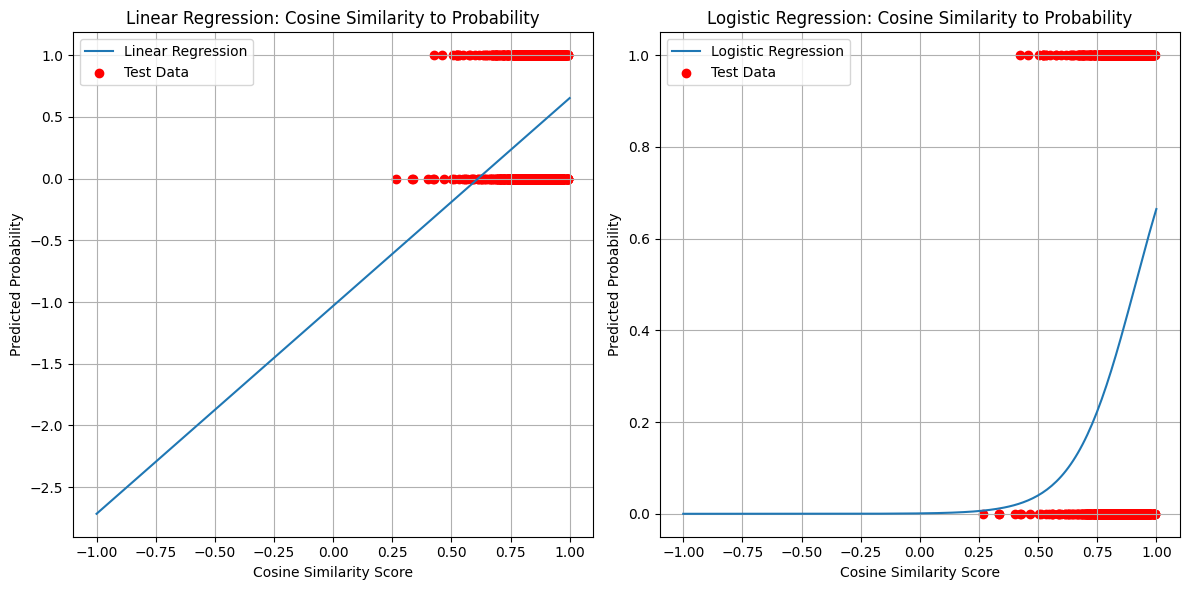

In [47]:
cosine_score_range1 = np.linspace(-1, 1, 200).reshape(-1, 1)

# Predict probabilities for the range of cosine scores
probabilities = calibration_model.predict(cosine_score_range1)
probabilities1 = calibration_model1.predict_proba(cosine_score_range1)[:, 1]

# Plot the relationship
plt.figure(figsize=(12, 6))

# Linear model plot
plt.subplot(1, 2, 1)
plt.plot(cosine_score_range1, probabilities, label='Linear Regression')
plt.scatter(X_test1, y_test1, color='red', label='Test Data')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Predicted Probability')
plt.title('Linear Regression: Cosine Similarity to Probability')
plt.legend()
plt.grid(True)

# Logistic model plot
plt.subplot(1, 2, 2)
plt.plot(cosine_score_range1, probabilities1, label='Logistic Regression')
plt.scatter(X_test1, y_test1, color='red', label='Test Data')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Predicted Probability')
plt.title('Logistic Regression: Cosine Similarity to Probability')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [46]:
print(3)

3


In [31]:
# def get_similarity_probability(model, text1, text2, threshold=0.5):
#     # Encode the texts
#     embedding1 = model.encode(text1, convert_to_tensor=True)
#     embedding2 = model.encode(text2, convert_to_tensor=True)
    
#     # Calculate cosine similarity
#     cosine_score = util.pytorch_cos_sim(embedding1, embedding2).item()
#     # Convert cosine similarity to a probability
#     # Assuming a simple linear conversion for demonstration purposes:
#     # You can use a different conversion method if you have a calibrated model.
#     print(cosine_score)
#     probability = (cosine_score + 1) / 8  # Cosine similarity ranges from -1 to 1

#     return probability

# # Example usage
# text1 = "sdfsdgsg"
# text2 = " "

# probability = get_similarity_probability(model, text1, text2)
# print(f"Probability that the output is 1: {probability:.4f}")

0.3913908302783966
Probability that the output is 1: 0.1739


In [98]:
import joblib

# Save the models to disk
joblib.dump(calibration_model, './calibration_model.pkl')
joblib.dump(calibration_model1, './calibration_model1.pkl')


['./calibration_model1.pkl']

Logged in as swan07


HfHubHTTPError:  (Request ID: Root=1-667b0d87-6784541b575626d42aa59c6d;8085b65b-4edc-4101-91ac-0aa99e612515)

403 Forbidden: You don't have the rights to create a dataset under the namespace "swan07".
Cannot access content at: https://huggingface.co/api/repos/create.
If you are trying to create or update content,make sure you have a token with the `write` role.

In [96]:
api.upload_folder(
    folder_path=temp_dir,
    repo_id=repo_id,
    token=hf_token,
    path_in_repo=model_name 
)

NameError: name 'temp_dir' is not defined